In [3]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
#import pyspark.pandas as psd
import os

try:
    os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()
    
    server = "localhost"
    port = "1433"
    database_name = "OLYMPICS"
    url = f"jdbc:sqlserver://{server}:{port};databaseName={database_name}"

    table_name = "athlete_events"
    password = "Passwd1234"
    username = "sa"

    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()
    
    print("Dane zostały pomyślnie wczytane z MSSQL Server")

except Exception as e:
    print(f"Wystąpił błąd podczas próby wczytania danych:\n\n{e}")

Dane zostały pomyślnie wczytane z MSSQL Server


# Procesy ETL

## ETL 1: Zamiana wartości M, F na Male, Female w kolumnie 'SEX'

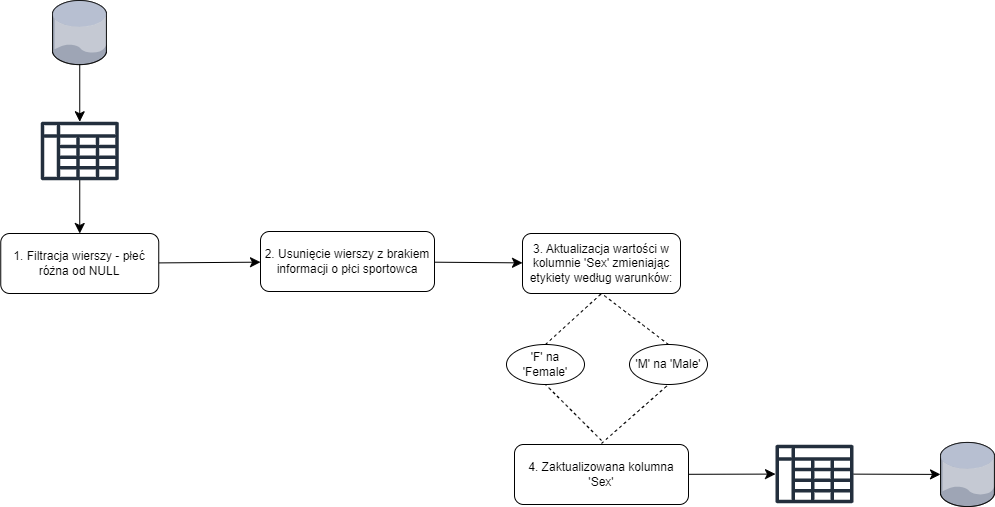

In [4]:
from IPython.display import Image
Image(filename='Dane/Photos/ETL1.png')

In [5]:
df.select('Sex').show(10)

+---+
|Sex|
+---+
|  M|
|  M|
|  M|
|  M|
|  F|
|  F|
|  F|
|  F|
|  F|
|  F|
+---+
only showing top 10 rows



In [6]:
#Sprawdzenie w ilu wierszach brakuje informacji nt. płci
notnull_sex_data = df.filter(df['Sex'].isNotNull()).count()
null_sex_data = df.filter(df['Sex'].isNull()).count()
total_rows = df.count()
percentagenn = (notnull_sex_data / total_rows) * 100
percentagen = (null_sex_data / total_rows) * 100
print(f"{notnull_sex_data}/{total_rows} - {percentagenn}%")
print(f"{null_sex_data}/{total_rows} - {percentagen}%")

271116/271597 - 99.8228993692861%
481/271597 - 0.1771006307138886%


In [7]:
#Usunięcie wierszy z brakującymi danymi nt. płci
removed_data = df.filter((df['Sex'].isNull()))
total_rows_before = df.count()

#1 i 2. Filtracja i wyrzucenie wierszy bez płci sportowca
df = df.filter((df['Sex'].isNotNull()))

total_rows_after = df.count()
removed_rows = removed_data.count()
print(f"Liczba wierszy przed wyczyszczeniem danych: {total_rows_before}")
print(f"Liczba wierszy po wyczyszczeniu danych: {total_rows_after}")
print(f"Liczba wyczyszczonych wierszy: {removed_rows}")

Liczba wierszy przed wyczyszczeniem danych: 271597
Liczba wierszy po wyczyszczeniu danych: 271116
Liczba wyczyszczonych wierszy: 481


In [8]:
#3. Zamiana wartośc M na Male oraz F na Female
df = df.withColumn("Sex",
                    when(df['Sex'] == "F", "Female")
                    .when(df['Sex'] == "M", "Male")
                    .otherwise(df['Sex']))

df.select('Sex').show(10)

+------+
|   Sex|
+------+
|  Male|
|  Male|
|  Male|
|  Male|
|Female|
|Female|
|Female|
|Female|
|Female|
|Female|
+------+
only showing top 10 rows



## ETL 2: Rozdzielenie kolumny Games na rok oraz sezon

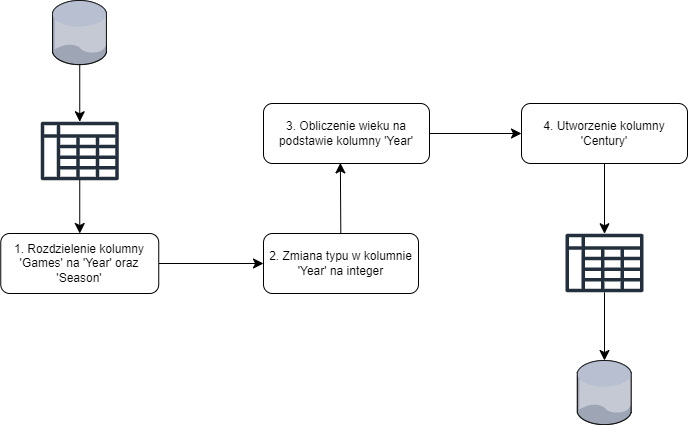

In [9]:
from IPython.display import Image
Image(filename='Dane/Photos/ETL2.png')

In [6]:
df.select('Games').show(10)

+-----------+
|      Games|
+-----------+
|1992 Summer|
|2012 Summer|
|1920 Summer|
|1900 Summer|
|1988 Winter|
|1988 Winter|
|1992 Winter|
|1992 Winter|
|1994 Winter|
|1994 Winter|
+-----------+
only showing top 10 rows



In [7]:
from pyspark.sql.functions import split, col

#1. Rozdzielenie kolumny na rok i sezon osobno
df = df.withColumn('Year', split(col('Games'), " ").getItem(0)) \
                   .withColumn('Season', split(col('Games'), " ").getItem(1))

#2. Zamiana typu danych w kolumnie Year na integer
df = df.withColumn('Year', col('Year').cast('int'))

df.select('Year', 'Season').show(10)

+----+------+
|Year|Season|
+----+------+
|1992|Summer|
|2012|Summer|
|1920|Summer|
|1900|Summer|
|1988|Winter|
|1988|Winter|
|1992|Winter|
|1992|Winter|
|1994|Winter|
|1994|Winter|
+----+------+
only showing top 10 rows



In [8]:
#3. Obliczenie wieku (stulecia) na podsatwie kolumny Year
df = df.withColumn('Century',
                   when(df['Year'].between(1801, 1900), 19)
                   .when(df['Year'].between(1901, 2000), 20)
                   .when(df['Year'].between(2001, 2100), 21))

#4. Utworzenie kolumny Century
df.select("Season", "Year", "Century").show(10)

+------+----+-------+
|Season|Year|Century|
+------+----+-------+
|Summer|1992|     20|
|Summer|2012|     21|
|Summer|1920|     20|
|Summer|1900|     19|
|Winter|1988|     20|
|Winter|1988|     20|
|Winter|1992|     20|
|Winter|1992|     20|
|Winter|1994|     20|
|Winter|1994|     20|
+------+----+-------+
only showing top 10 rows



## ETL 3: Zamiana wieku na przedział wiekowy

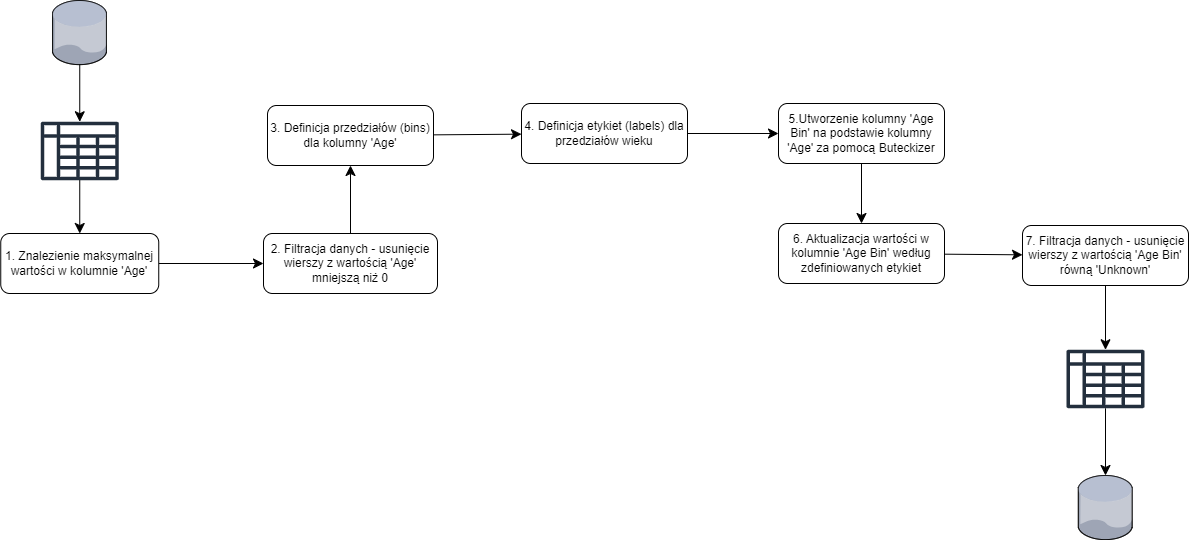

In [10]:
from IPython.display import Image
Image(filename='Dane/Photos/ETL3.png')

In [9]:
df.select('Age').show(10)

+----+
| Age|
+----+
|24.0|
|23.0|
|24.0|
|34.0|
|21.0|
|21.0|
|25.0|
|25.0|
|27.0|
|27.0|
+----+
only showing top 10 rows



In [10]:
from pyspark.sql import functions as F

#1. Znalezienie maksymalnej wartości w kolumnie Age (największy wiek sportowca)
print(df.select(F.max('Age')).collect()[0][0])

97.0


In [11]:
from pyspark.ml.feature import Bucketizer

#2. Usunięcie wierszy, w którym brak informacji o wieku sportowca
df = df.filter(df['Age'] >= 0)

#3. Definicja przedziałów wiekowych
bins = [0, 20, 25, 30, 40, 60, 100]

#4. Definicja etykiet przedziałów wiekowych
labels = [str(bins[i-1] + 1) + "-" + str(bins[i]) for i in range(1, len(bins))]

#5. Utworzenie kolumny Age Bin (z przedziałem wiekowym) na podstawie kolumny Age za pomocą bucketizera
przedzialy = Bucketizer(splits = bins, inputCol='Age', outputCol = 'Age Bin')

df = przedzialy.setHandleInvalid("keep").transform(df)

#6. Aktualizacja wartości w kolumnie Age Bin według obliczonych etykiet
df = df.withColumn('Age Bin',
                   when(df['Age Bin'] == 0.0, labels[0])
                   .when(df['Age Bin'] == 1.0, labels[1])
                   .when(df['Age Bin'] == 2.0, labels[2])
                   .when(df['Age Bin'] == 3.0, labels[3])
                   .when(df['Age Bin'] == 4.0, labels[4])
                   #.when(df['Age Bin'] == 5.0, labels[5])
                   #.when(df['Age Bin'] == 6.0, labels[6])
                   #.when(df['Age Bin'] == 7.0, labels[7])
                   #.when(df['Age Bin'] == 8.0, labels[8])
                   .otherwise("Unknown"))

#7. Filtracja danych - usunięcie wartości w kolumnie Age Bin, z nierozpoznanymi przedziałami wiekowymi
df = df.filter((df['Age Bin'] != "Unknown"))

df.select('Age Bin').distinct().show(10)

+-------+
|Age Bin|
+-------+
|  21-25|
|  26-30|
|  31-40|
|   1-20|
|  41-60|
+-------+



# ETL 4: Zamiana wartości w kolumnie medal na odpowiednio: G - Gold, S - Silver, B - Bronze, NA - No medal

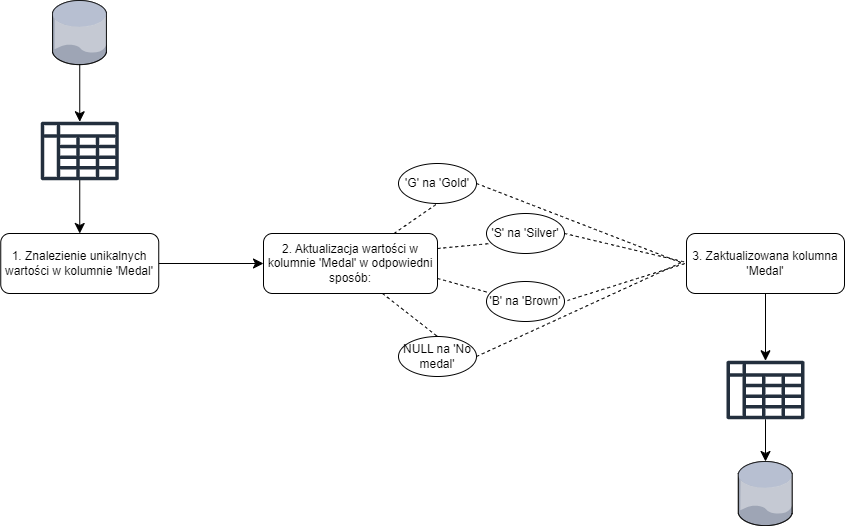

In [11]:
from IPython.display import Image
Image(filename='Dane/Photos/ETL4.png')

In [12]:
#1. Znalezienie unikalnych wartości w kolumnie medal
df.select("Medal").distinct().show(4)

+-----+
|Medal|
+-----+
|    B|
|    S|
|    G|
| NULL|
+-----+



In [13]:
#2. Aktualizacja wartości w kolumnie medal wedug odpowiednich kryteriów
df = df.withColumn('Medal',
                   when(col('Medal') == 'G', 'Gold')
                   .when(col('Medal') == 'S', 'Silver')
                   .when(col('Medal') == 'B', 'Bronze')
                   .when(col('Medal').isNull(), 'No medal')
                   .otherwise(col('Medal')))

#3. Zaktualizowana kolumna medal
df.select('Medal').distinct().show(4)

+--------+
|   Medal|
+--------+
|  Silver|
|    Gold|
|No medal|
|  Bronze|
+--------+



## ETL 5: Stworzenie kolumny 'Continent' na podstawie kraju pochodzenia sportowca

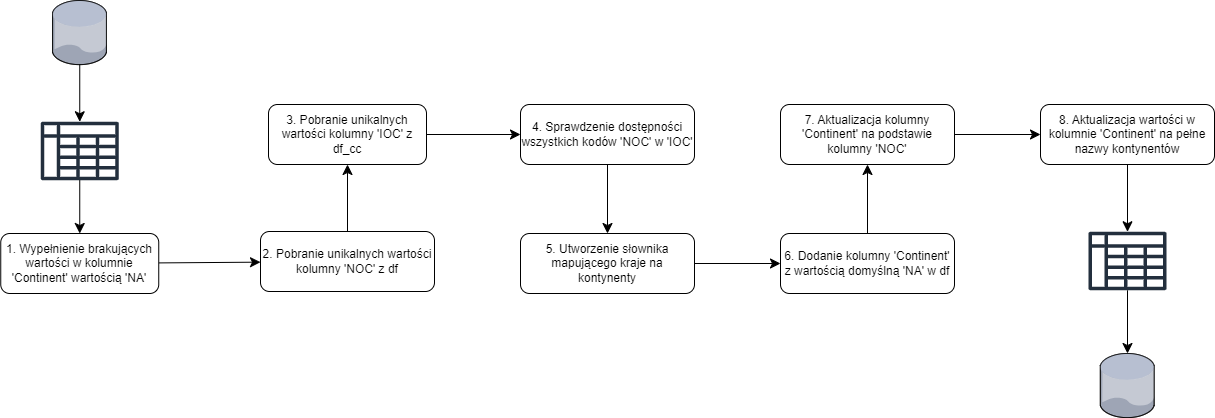

In [12]:
from IPython.display import Image
Image(filename='Dane/Photos/ETL5.png')

In [14]:
import pandas as pd

#0. Wczytanie pomocniczej ramki danych df_cc
df_cc = pd.read_csv('Dane/country-codes.csv')

#1. Wypełnienie brakujących wartości w kolumnie Continent na NA (program bazowo wczytał NA - North America jako wartości NULL)
df_cc['Continent'].fillna('NA', inplace=True)

df_cc.head()

C:\Users\Piotrek\AppData\Local\Temp\ipykernel_6092\2977158882.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cc['Continent'].fillna('NA', inplace=True)


,IOC,Continent
0,TPE,AS
1,AFG,AS
2,ALB,EU
3,ALG,AF
4,ASA,OC


In [15]:
#Sprawdzamy czy wszystkie kod zawarte w naszej tabeli znajdują się również w ramce danych z kodami kontynentów
#2. Pobranie unikalnych wartości w kolumnie NOC z oryginalnej ramki danych (kody/symbole państw)
unique_noc = df.agg(F.collect_set('NOC')).first()[0]

#3. Pobranie unikalnych wartości z kolumny IOC z pomocniczej ramki danych (kody/symbole państw)
unique_ioc = df_cc['IOC'].unique()

#4. Sprawdzenie dostępności wszystkich etykiet w pomocniczej ramce danych
print("Wszystkie kody są dostępne") if set(unique_noc).issubset(set(unique_ioc)) else print("Brakuje kodów")

Wszystkie kody są dostępne


In [16]:
from pyspark.sql.functions import lit

#5. Utworzenie słownika mapującego kraje na kontynenty
country_to_continent = dict(zip(df_cc['IOC'], df_cc['Continent']))

#6. Dodanie nowej kolumny 'Continent' do oryginalnej ramki danych z domyślną wartością NA
df = df.withColumn('Continent', lit('NA'))

#7. Aktualizacja kolumny Continent na podstawie kolumny NOC i wyszukiwania słownikowego
for country, continent in country_to_continent.items():
    df = df.withColumn('Continent',
                       when(col('NOC') == country, continent)
                       .otherwise(col('Continent')))

df.select('Team', 'Continent').distinct().show(10)

+--------------------+---------+
|                Team|Continent|
+--------------------+---------+
|    Vesper Boat Club|       NA|
|     Pistoja/Firenze|       EU|
|              Kosovo|       EU|
|           Belarus-2|       EU|
|             Sheerio|       EU|
|               Kenya|       AF|
|Central African R...|       AF|
|            Sorais-2|       EU|
|              Hayama|       EU|
|           Belgium-3|       EU|
+--------------------+---------+
only showing top 10 rows



In [17]:
print(df_cc['Continent'].unique())

['AS' 'EU' 'AF' 'OC' 'NA' 'AN' 'SA' 'UT']


In [18]:
#8. Zamiana skrótów kontynentów na ich pełne nazwy
df = df.withColumn("Continent",
                    when(df['Continent'] == "AS", "Asia")
                    .when(df['Continent'] == "EU", "Europe")
                    .when(df['Continent'] == "AF", "Africa")
                    .when(df['Continent'] == "OC", "Oceania")
                    .when(df['Continent'] == "NA", "North America")
                    .when(df['Continent'] == "SA", "South America")
                    .when(df['Continent'] == "AN", "Antarctica")
                    .when(df['Continent'] == "UT", "Unified Team")
                    .otherwise(df['Sex']))

df.select('Team', 'Continent').show(10)

+--------------+---------+
|          Team|Continent|
+--------------+---------+
|         China|     Asia|
|         China|     Asia|
|       Denmark|   Europe|
|Denmark/Sweden|   Europe|
|   Netherlands|   Europe|
|   Netherlands|   Europe|
|   Netherlands|   Europe|
|   Netherlands|   Europe|
|   Netherlands|   Europe|
|   Netherlands|   Europe|
+--------------+---------+
only showing top 10 rows



In [19]:
#GOTOWA RAMKA DANYCH
df.show(10)

+---+--------------------+------+----+------+------+--------------+---+-----------+-----------+-------------+--------------------+--------+----+------+-------+-------+---------+
| ID|                Name|   Sex| Age|Height|Weight|          Team|NOC|      Games|       City|        Sport|               Event|   Medal|Year|Season|Century|Age Bin|Continent|
+---+--------------------+------+----+------+------+--------------+---+-----------+-----------+-------------+--------------------+--------+----+------+-------+-------+---------+
|  1|           A Dijiang|  Male|24.0| 180.0|  80.0|         China|CHN|1992 Summer|  Barcelona|   Basketball|Basketball Men's ...|No medal|1992|Summer|     20|  21-25|     Asia|
|  2|            A Lamusi|  Male|23.0| 170.0|  60.0|         China|CHN|2012 Summer|     London|         Judo|Judo Men's Extra-...|No medal|2012|Summer|     21|  21-25|     Asia|
|  3| Gunnar Nielsen Aaby|  Male|24.0|  NULL|  NULL|       Denmark|DEN|1920 Summer|  Antwerpen|     Football|F

# Zapisanie tabeli do bazy danych

In [20]:
try:
    server = "localhost"
    port = "1433"
    database_name = "OLYMPICS"
    url = f"jdbc:sqlserver://{server}:{port};databaseName={database_name}"

    table_name = "athlete_events_prepared"
    password = "Passwd1234"
    username = "sa"

    df.write \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .mode("overwrite") \
        .save()
    
    pandas_df = df.toPandas()
    pandas_df.to_csv('Dane/olympic_data_prepared.csv', index = False)
    
    print("Pomyślnie zapisano sformatowaną i wyczyszczoną tabelę!")

except Exception as e:
    print(f"Wystąpił błąd podczas próby zapisu tabeli:\n\n{e}")

finally:
    spark.stop()
    print('SPARK SESSION WAS TERMINATED')

Pomyślnie zapisano sformatowaną i wyczyszczoną tabelę!
SPARK SESSION WAS TERMINATED
